In [158]:
import numpy as np
import pickle
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.layers import Embedding, LSTM, Add
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm.notebook import tqdm

#  load documents into memory

In [117]:
# function to load documents into memory
def load_doc(filename):
    # Open file to read
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [3]:
!pwd

/home/jupyter/robo-romeo/notebooks


# Create the dataframe for train and test

In [159]:
# create dataframe from cleaned descriptions.txt file. pass file path to function to create
def get_dataframe(folder_path, vocab_size):
    
    dataframe = load_doc(folder_path)
    dataframe = dataframe.split('\n')

    l_all =[]
    for n in dataframe:
        line = {"id": n.split(" ")[0],
            'value': "startsequence " + " ".join(n.split(" ")[1:]) + " endsequence"}
        l_all.append(line)

    df_all = pd.DataFrame(l_all)

    t = Tokenizer(num_words=vocab_size)
    t.fit_on_texts(df_all.value)

    df_all["value_tokenized"] = t.texts_to_sequences(df_all.value)

    train_ids = np.unique(df_all.id)[:int(0.8*len(np.unique(df_all.id)))]
    test_ids = np.unique(df_all.id)[int(0.8*len(np.unique(df_all.id))):]

    df_train = df_all[df_all.id.isin(train_ids)]
    df_test = df_all[df_all.id.isin(test_ids)]

    return df_train,df_test,t

In [160]:
vocab_size = 10000

In [161]:
desc_file = '/home/jupyter/robo-romeo/data/descriptions.txt'

In [162]:
df_train, df_test, tokenizer = get_dataframe(desc_file,vocab_size)

In [163]:
len(df_train)

127130

In [164]:
len(tokenizer.index_word)

19573

In [86]:
tokenizer.texts_to_sequences(['unqueue a girl'])

[[1, 19]]

In [165]:
file = open('/home/jupyter/robo-romeo/data/word_index_attention_10k.pkl', 'wb')
pickle.dump(tokenizer.word_index, file)

# Create all the input for training model

In [138]:
class DataPipeline(tf.keras.utils.Sequence):

    def __init__(self,df,batch_size,vocab_size,cap_len,img_folder_path,model,force_encoding=False):
        self.df = df
        self.prepare_dataset()
        self.batch_size = batch_size
        self.vocab_size = vocab_size
        self.cap_len = cap_len
        self.img_folder_path = img_folder_path
        self.encoder_model = model
        self.encode_all_images(force_encoding)
        

    def prepare_dataset(self):
        # for loop to append X1,X2,y
        X1,X2,y = [],[],[]

        for idx, data in self.df.iterrows():

            seq = data["value_tokenized"]
            for i in range(1,len(seq)):
                X1.append(data["id"])
                X2.append(seq[0:i])
                y.append(seq[i])

        self.X1,self.X2,self.y = X1, X2, y

    def encode_all_images(self,force_encoding):

        l_toencode = np.unique(self.X1)
        dic_encoded={}
        for image_name in tqdm(l_toencode):
            img_path = self.img_folder_path+image_name + ".jpg"
            arr_path = self.img_folder_path+image_name + ".npy"
            if os.path.exists(img_path):
                if force_encoding or not os.path.exists(arr_path):
                    img = image.load_img(img_path, target_size=(256,256,3))
                    x = image.img_to_array(img)
                    x = np.expand_dims(x, axis=0)
                    arr= self.encoder_model.predict(x)[0]
                    np.save(open(arr_path, 'wb'),arr)

    def load_images_encoded(self, imgs_to_load):

        #l_toencode = np.unique(imgs_to_load)
        #dic_encoded={}
        features = []
        for image_name in imgs_to_load:
            arr_path = self.img_folder_path+image_name + ".npy"
            features.append(np.load(open(arr_path, 'rb')))

        #features = []
        #for image_name in imgs_to_load:
        #    features.append(dic_encoded[image_name])

        final_array = np.array(features)
        return final_array

    def seq_to_padded(self,seq_to_pad):
        inputs_seq_model = pad_sequences(seq_to_pad,padding='post',maxlen=self.cap_len)

        return inputs_seq_model

    def to_cat(self, y_to_cat):
        # function to categorical
        y = tf.keras.utils.to_categorical(y_to_cat, num_classes=self.vocab_size)
        return y

    def __getitem__(self,idx):
        imgs_to_load = self.X1[idx * self.batch_size : (idx +1) * self.batch_size]
        x1_batch = self.load_images_encoded(imgs_to_load)

        seq_to_pad = self.X2[idx * self.batch_size : (idx +1) * self.batch_size]
        x2_batch = self.seq_to_padded(seq_to_pad)

        y_to_cat = self.y[idx * self.batch_size : (idx +1) * self.batch_size]
        y_batch = self.to_cat(y_to_cat)

        return ([x1_batch,
                x2_batch],
                y_batch)

    def __len__(self):
        return len(self.X1)// self.batch_size

## CNN and LSTM Model layers

In [144]:
cap_len = 25
embed_dim = 1024

In [145]:
img_folder_path = '/home/jupyter/robo-romeo/notebooks/flickr30k/images/'

In [146]:
cnn_model = EfficientNetB0(include_top=False,weights='imagenet', input_shape= (256,256,3))

In [147]:
inputs2  = Input(shape=(cap_len,),name="captions")
embed_layer = Embedding(vocab_size+1, embed_dim, mask_zero=True)(inputs2)

input_encoded = Input(shape=(8,8,1280),name="images_encoded")
features = tf.keras.layers.Reshape((64, input_encoded.shape[-1]))(input_encoded)
cnn_dense = Dense(embed_dim, activation='relu')(features)

cnn_socre = tf.keras.layers.Dense(256)(cnn_dense)

seq_context = LSTM(256)(embed_layer)
seq_context = tf.expand_dims(seq_context, 1)
seq_score = tf.keras.layers.Dense(256)(seq_context)

combine_score = Add()([cnn_socre,seq_score])
combine_score_activation = tf.nn.tanh(combine_score)

attention_scores = Dense(1)(combine_score_activation)
attention_weights = tf.nn.softmax(attention_scores, axis=1)

heatmaped_image = tf.keras.layers.Multiply()([cnn_dense,attention_weights])
pooling_heatmaped = tf.keras.layers.GlobalAveragePooling1D()(heatmaped_image)


combine = Add()([embed_layer,pooling_heatmaped])
lstm_layer = LSTM(embed_dim)(combine)
decoder = Dense(2048, activation='relu')(lstm_layer)
outputs = Dense(vocab_size, activation='softmax')(decoder)

In [152]:
lstm_model = Model(inputs=[input_encoded, inputs2], outputs=outputs)
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

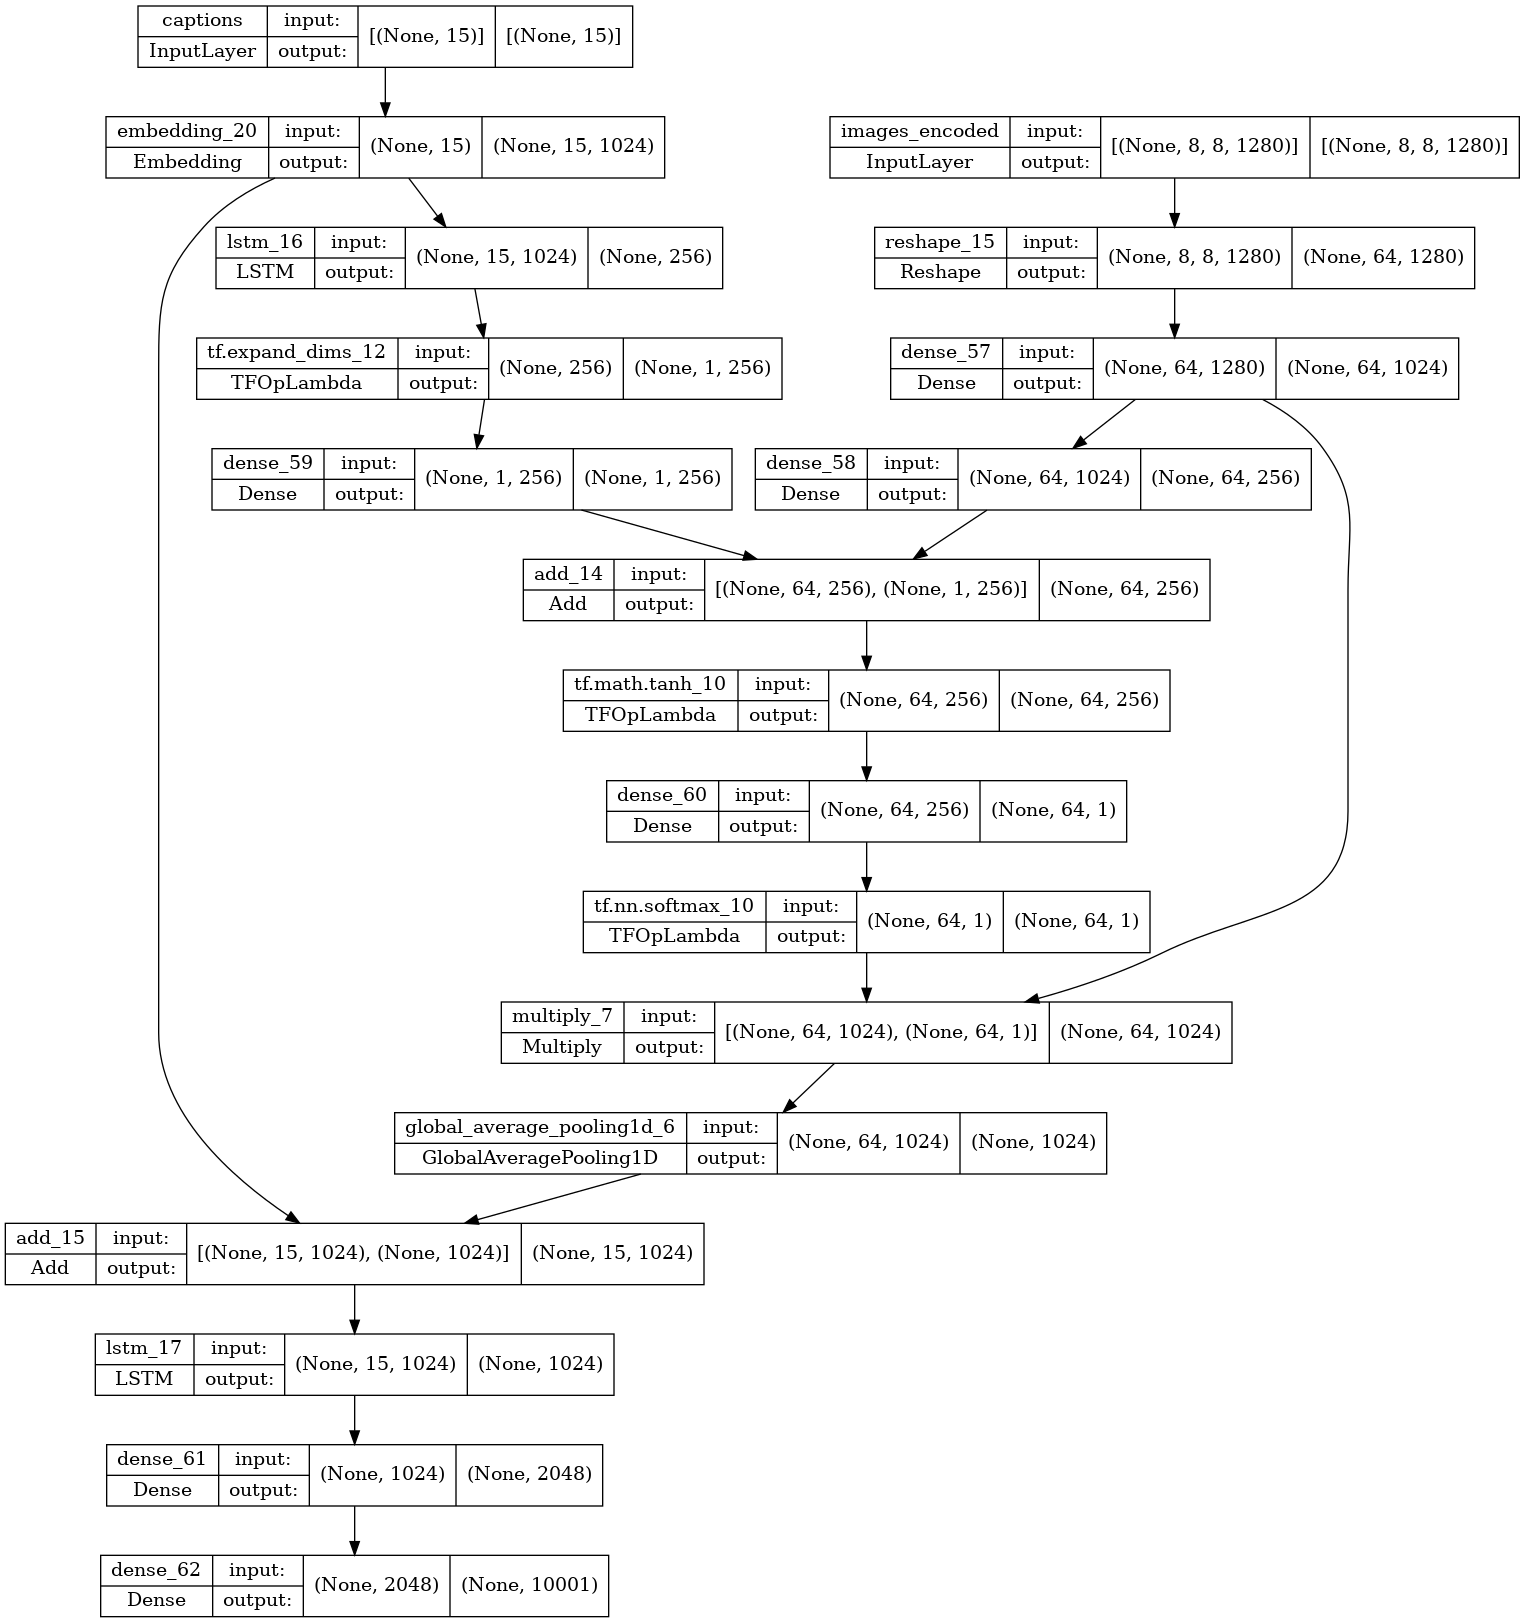

In [98]:
tf.keras.utils.plot_model(lstm_model,show_shapes=True)

In [153]:
lstm_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 captions (InputLayer)          [(None, 25)]         0           []                               
                                                                                                  
 embedding_23 (Embedding)       (None, 25, 1024)     10241024    ['captions[0][0]']               
                                                                                                  
 images_encoded (InputLayer)    [(None, 8, 8, 1280)  0           []                               
                                ]                                                                 
                                                                                                  
 reshape_18 (Reshape)           (None, 64, 1280)     0           ['images_encoded[0][0]']   

In [154]:
batch_size = 2048

In [155]:
train_batch = DataPipeline(df_train, batch_size, vocab_size, cap_len, img_folder_path, cnn_model, force_encoding=False)

  0%|          | 0/25426 [00:00<?, ?it/s]

In [157]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_attention_checkpoint_30k_caplen25.h5',
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

lstm_model.fit(train_batch, epochs=40, verbose=1, callbacks=[model_checkpoint_callback])
lstm_model.save_weights('/home/jupyter/robo-romeo/data/20220614_attention_caplen25_modelweights.h5')

Epoch 1/40
743/743 [==============================] - 1266s 2s/step - loss: 4.1809 - accuracy: 0.2758
Epoch 2/40
743/743 [==============================] - 1266s 2s/step - loss: 3.3560 - accuracy: 0.3463
Epoch 3/40
743/743 [==============================] - 1248s 2s/step - loss: 3.0183 - accuracy: 0.3748
Epoch 4/40
743/743 [==============================] - 1254s 2s/step - loss: 2.7760 - accuracy: 0.3953
Epoch 5/40
184/743 [======>.......................] - ETA: 14:46 - loss: 2.5204 - accuracy: 0.4212

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



743/743 [==============================] - 1079s 1s/step - loss: 0.8823 - accuracy: 0.7542
Epoch 15/40
743/743 [==============================] - 1077s 1s/step - loss: 0.7968 - accuracy: 0.7765
Epoch 16/40
743/743 [==============================] - 1081s 1s/step - loss: 0.7274 - accuracy: 0.7941
Epoch 17/40
743/743 [==============================] - 1082s 1s/step - loss: 0.6679 - accuracy: 0.8094
Epoch 18/40
743/743 [==============================] - 1081s 1s/step - loss: 0.6227 - accuracy: 0.8204
Epoch 19/40
743/743 [==============================] - 1078s 1s/step - loss: 0.5819 - accuracy: 0.8304
Epoch 20/40
743/743 [==============================] - 1082s 1s/step - loss: 0.5456 - accuracy: 0.8397
Epoch 21/40
743/743 [==============================] - 1083s 1s/step - loss: 0.5185 - accuracy: 0.8462
Epoch 22/40
743/743 [==============================] - 1081s 1s/step - loss: 0.4957 - accuracy: 0.8516
Epoch 23/40
743/743 [==============================] - 1082s 1s/step - loss: 0.4711 -

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



743/743 [==============================] - 1142s 2s/step - loss: 0.3586 - accuracy: 0.8827
Epoch 35/40
743/743 [==============================] - 1085s 1s/step - loss: 0.3519 - accuracy: 0.8843
Epoch 36/40
743/743 [==============================] - 1084s 1s/step - loss: 0.3487 - accuracy: 0.8846
Epoch 37/40
743/743 [==============================] - 1081s 1s/step - loss: 0.3473 - accuracy: 0.8849
Epoch 38/40
213/743 [=======>......................] - ETA: 12:50 - loss: 0.3182 - accuracy: 0.8945

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



# Predict the results

In [22]:
import matplotlib.pyplot as plt

In [29]:
def CNN_output(file_id):
    
    CNN_model = EfficientNetB0(
    include_top=False, # Whether to include the fully-connected layer at the top of the network
    weights='imagenet', # pre-trained weights on ImageNet
    input_tensor=None,
    input_shape= (256,256,3), # It should have exactly 3 inputs channels
    pooling=None # Optional pooling mode for feature extraction when include_top is False
    )
    test_img_path = f"../raw_data/pics/Flicker8k_Dataset/{file_id}"
    
    test_img= image.load_img(test_img_path, target_size=(256,256,3))
    x_test = image.img_to_array(test_img)
    x_test = np.expand_dims(x_test, axis=0)
    test = CNN_model.predict(x_test)
    return test

In [30]:
def predic_seq(img_encoded):   
    inputs_seq='startsequence'
    inputs_seq = [2]
    for i in range(36):
        inputs_seq_model = pad_sequences([inputs_seq],padding='post',maxlen=36)
        y_pre = model.predict([img_encoded,inputs_seq_model])
        next_word = y_pre.argmax()
        if next_word == 3:
            break
        inputs_seq.append(next_word)
    return inputs_seq

In [31]:
def output_sentence(inputs_seq):
    # file ='../output/extracted_features/word_index'
    # test_img_path = "../raw_data/pics/Flicker8k_Dataset/2458269558_277012780d.jpg"
    # test_img= image.load_img(test_img_path, target_size=(256,256,3))
    sentence  = []
    # with open(file,'rb') as dictionary:
    b = t.word_index
    for number in inputs_seq:     
        sentence.append(list(b.keys())[list(b.values()).index(number)])
        final_sentence  = ' '.join(word for word in sentence[1:])
    return final_sentence
    # return test_img

In [32]:
f"{X_test.id.unique()[0]}.jpg"

'3601569729_bf4bf82768.jpg'

In [33]:
def test_pre(number_image):
    img_list = X_test.id.unique()
    img_folder_path = '../raw_data/pics/Flicker8k_Dataset/'
    images = number_image
    rand_img_index = np.random.randint(1001, size=images)
    rand_images = [img_list[i] for i in rand_img_index]
    # fig = plt.figure(figsize=(30,20));
    with open('../raw_data/text/Flickr8k.token.txt') as token_file:
        lines = token_file.readlines()
    image_tags = []
    captions = []
    for line in range(0,len(lines)):
        image_tags.append(lines[line].split('#')[0])
        captions.append(((lines[line].split('#')[1]).split('\t')[1]).split(' .')[0])
    for i in range(0,images):
        fig = plt.figure(figsize=(50,30));
        cnn_out = CNN_output(rand_images[i]+'.jpg')
        seq_out = predic_seq(cnn_out)
        sent_out = output_sentence(seq_out)
        plt.subplot(images,1,i+1);
        img = image.load_img(img_folder_path+rand_images[i]+'.jpg')
        image_out =plt.imshow(img);
        final_out =plt.title(f"Actual: {captions[image_tags.index(rand_images[i]+'.jpg')]} \n Prediction: {sent_out}");
        
    
    # plt.title(sent_out)
    # return final_out, image_out

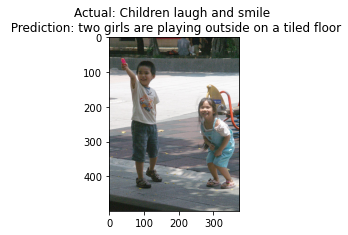

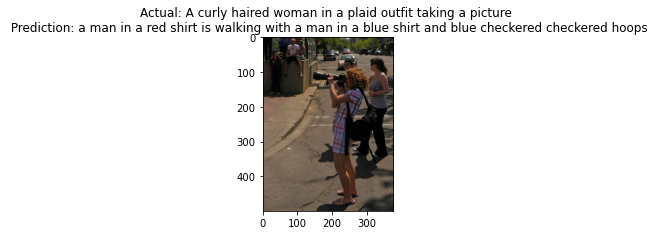

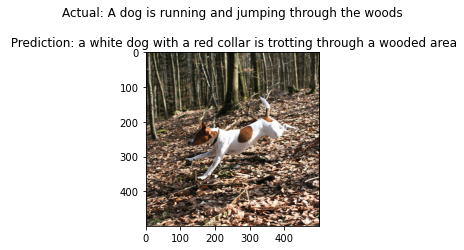

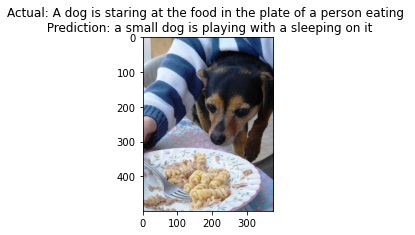

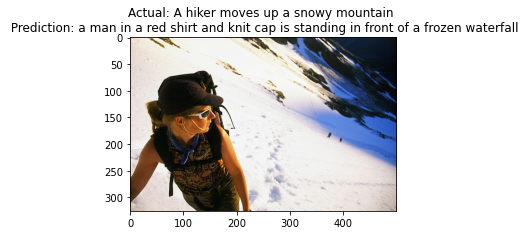

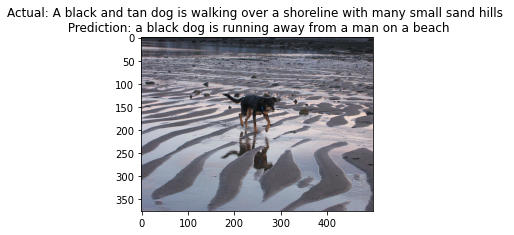

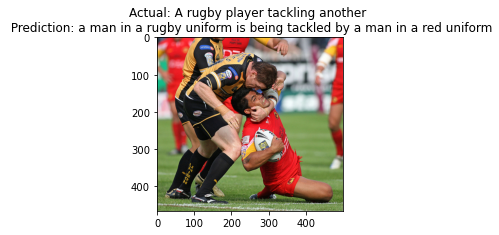

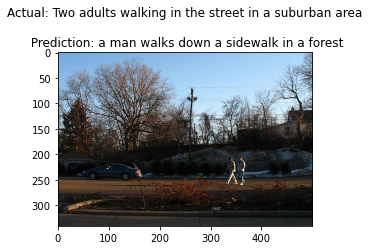

In [34]:
test_pre(8)

# Learning curve 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()